In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [159]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

Kích thước tập huấn luyện: (120, 4)
Kích thước tập kiểm tra: (30, 4)


In [160]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
y_kmeans_train = kmeans.fit_predict(X_train)

# Thêm nhãn cụm vào dataframe huấn luyện để dễ dàng thao tác
train_df = pd.DataFrame(X_train, columns=feature_names)
train_df['cluster'] = y_kmeans_train
train_df['original_label'] = y_train

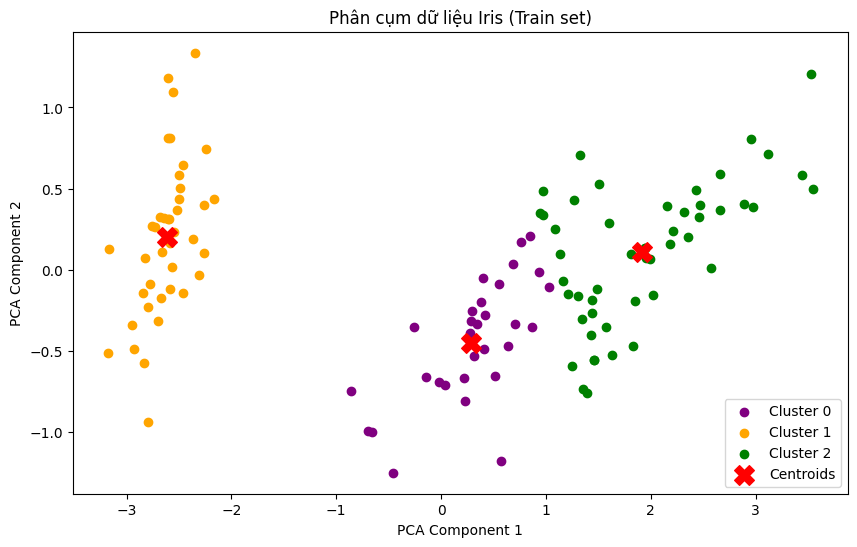

In [161]:
# 4. Vẽ biểu đồ phân cụm (sử dụng PCA để giảm chiều dữ liệu xuống 2D)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(10, 6))

# Ánh xạ màu cho các nhãn
unique_clusters = np.unique(y_kmeans_train)
colors = ['purple', 'orange', 'green']  # Danh sách màu cho từng cụm
cluster_color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Vẽ các điểm dữ liệu với màu tương ứng cụm
for cluster, color in cluster_color_map.items():
    plt.scatter(X_train_pca[y_kmeans_train == cluster, 0], 
                X_train_pca[y_kmeans_train == cluster, 1], 
                color=color, label=f'Cluster {cluster}')

# Vẽ centroids sau khi PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, color='red', label='Centroids')

plt.title('Phân cụm dữ liệu Iris (Train set)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()  # Hiển thị chú thích
plt.show()


In [162]:
cluster_labels = np.zeros_like(y_kmeans_train)
for i in range(kmeans.n_clusters):
    mode_label = train_df[train_df['cluster'] == i]['original_label'].mode()
    if not mode_label.empty:
        cluster_labels[y_kmeans_train == i] = mode_label[0]
    else:
        # Xử lý trường hợp cụm không có dữ liệu (thường không xảy ra với K-Means)
        print(f"Cụm {i} không có dữ liệu.")

# Tạo nhãn cụm cho tập test dựa trên mô hình K-Means đã huấn luyện
y_kmeans_test = kmeans.predict(X_test)
cluster_labels_test = np.zeros_like(y_kmeans_test)
for i in range(kmeans.n_clusters):
    mode_label = train_df[train_df['cluster'] == i]['original_label'].mode()
    if not mode_label.empty:
        cluster_labels_test[y_kmeans_test == i] = mode_label[0]
    else:
        print(f"Cụm {i} không có dữ liệu trong tập test.")

print("Nhãn cụm cho tập huấn luyện (5 mẫu đầu):", cluster_labels[:5])
print("Nhãn gốc cho tập huấn luyện (5 mẫu đầu):", y_train[:5])
print("Nhãn cụm cho tập kiểm tra (5 mẫu đầu):", cluster_labels_test[:5])
print("Nhãn gốc cho tập kiểm tra (5 mẫu đầu):", y_test[:5])

Nhãn cụm cho tập huấn luyện (5 mẫu đầu): [0 0 2 0 0]
Nhãn gốc cho tập huấn luyện (5 mẫu đầu): [0 0 1 0 0]
Nhãn cụm cho tập kiểm tra (5 mẫu đầu): [1 0 2 1 2]
Nhãn gốc cho tập kiểm tra (5 mẫu đầu): [1 0 2 1 1]


In [163]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, cluster_labels)

# Dự đoán nhãn trên tập kiểm tra
y_pred = model.predict(X_test)


Đánh giá mô hình trên tập kiểm tra:
Độ chính xác (Accuracy): 0.90
F1-score (Weighted): 0.90
Precision (Weighted): 0.92
Recall (Weighted): 0.90

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.67      0.80         9
   virginica       0.79      1.00      0.88        11

    accuracy                           0.90        30
   macro avg       0.93      0.89      0.89        30
weighted avg       0.92      0.90      0.90        30



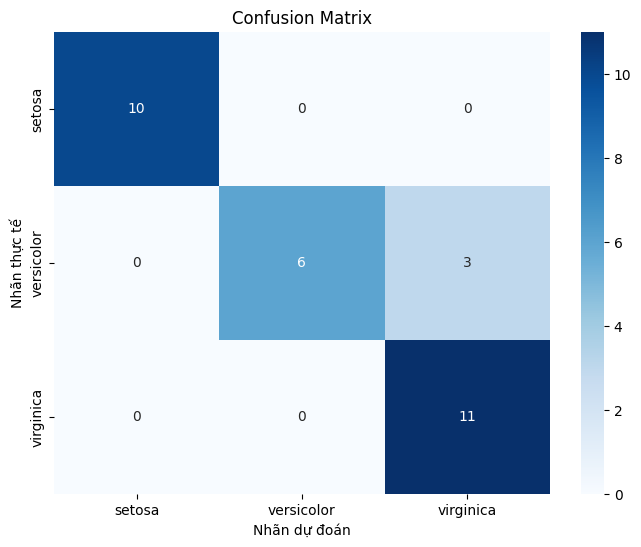

In [164]:
# 7. Đánh giá độ chính xác và các thông số khác
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, target_names=target_names)
cm = confusion_matrix(y_test, y_pred)

print(f"\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Độ chính xác (Accuracy): {accuracy:.2f}")
print(f"F1-score (Weighted): {f1:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")

print("\nClassification Report:")
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.show()
